<a href="https://colab.research.google.com/github/charlesreid1/dib-deep-chem/blob/master/ch6/deepchem_ch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

Start by importing tensorflow and seeing if there is a GPU device available.

In [0]:
import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#    raise SystemError('GPU device not found')

Install miniconda, then install prerequisites for deepchem:

In [2]:
%%bash
if [ -f /usr/local/bin/conda ]; then
  echo 'conda installed already!'
else
  echo 'conda not installed; going for it!'
  curl -O -L https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
  bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
fi

# install important things
conda install -y --prefix /usr/local -c conda-forge rdkit joblib simdna

conda installed already!
Solving environment: ...working... done

# All requested packages already installed.



Now set the `$PYTHONPATH` variable so that the notebook can access all the packages we installed above:

In [0]:
import os
os.environ['PYTHONPATH'] = os.environ['PYTHONPATH'] + ':/usr/local/lib/python3.6/site-packages:/usr/local/lib/python3.7/site-packages'

Install [PBR (python build reasonableness)](https://launchpad.net/pbr):

In [4]:
!pip install pbr

Install deepchem from source:

In [5]:
%%bash
# now install deepchem from source

if [ \! -d deepchem-repo ]; then
  git clone https://github.com/deepchem/deepchem.git deepchem-repo
fi
cd deepchem-repo && python setup.py install

running install
[pbr] Writing ChangeLog
[pbr] Generating ChangeLog
[pbr] ChangeLog complete (0.1s)
[pbr] Generating AUTHORS
[pbr] AUTHORS complete (0.1s)
running build
running build_py
running egg_info
writing deepchem.egg-info/PKG-INFO
writing dependency_links to deepchem.egg-info/dependency_links.txt
writing top-level names to deepchem.egg-info/top_level.txt
writing pbr to deepchem.egg-info/pbr.json
[pbr] Processing SOURCES.txt
[pbr] In git context, generating filelist from git
reading manifest template 'MANIFEST.in'
writing manifest file 'deepchem.egg-info/SOURCES.txt'
running install_lib
running install_egg_info
removing '/usr/local/lib/python3.7/site-packages/deepchem-2.2.1.dev49-py3.7.egg-info' (and everything under it)
Copying deepchem.egg-info to /usr/local/lib/python3.7/site-packages/deepchem-2.2.1.dev49-py3.7.egg-info
running install_scripts


/usr/local/lib/python3.7/site-packages/pbr/packaging.py:410: EasyInstallDeprecationWarning: Use get_header
  header = easy_install.get_script_header("", executable, is_wininst)


Add the site packages location to the system path:

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
sys.path.append('/usr/local/lib/python3.6/site-packages')

# Transcription Factor Example



## Overview

This example will use a data set about a transcription factor called JUND. The data set used in this example comes from the human chromosome 22 (the smallest human chromosome). It is 50 Mbp.

The chromosome is broken into short segments of 101 base pairs.

One hot encoding is used to represent the sequences (i.e., each base pair is turned into a vector of 0s and 1s).

In [7]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

fatal: destination path 'DeepLearningLifeSciences' already exists and is not an empty directory.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

## Neural Network Architecture

Beacuse we are dealing with a 1D sequence of data, we use a convolutional neural network that performs the convolution in 1 dimension (rather than 2 dimensions usually used with image data).

Import necessary modules to build our neural network model:

In [0]:
import deepchem as dc
import tensorflow as tf
import numpy as np
import deepchem.models.tensorgraph.layers as layers

Now we create the ingredients required by our model.

The model is a TensorGraph model. We assemble the model layer by layer.

The model must have labels (names for columns of data) and weights (for the input data).

In [0]:
# Create model:
model = dc.models.TensorGraph(batch_size=1000)
features = layers.Feature(shape=(None, 101, 4))
labels = layers.Label(shape=(None, 1))
weights = layers.Weights(shape=(None, 1))

Convolution neural networks usually follow a scheme that includes the following layers in order:

The following neural network layer combo composes a single convolution layer:

* Convolution (multiple convolution layers to deal with different portions of the data, e.g., 2 convolution layers each handing half the image)
* Pool (combine convolutions)
* Dropout (filter information - optional)

These layers are repeated one or more times. Once the convolution layers have been implemented, the following layers are added to the end to convert the neural network's output into a usable classification/prediction:

* Flatten (change dimensionality)
* Dense
* Dropout (filter information - optional)
* Dense

In [0]:
# Set model architecture:

# Three convolutional layers with identical parameters
prev = features
convolution_window = 10
for i in range(3):
    prev = layers.Conv1D(filters=15, 
                         kernel_size=convolution_window,
                         activation=tf.nn.relu, 
                         padding='same',
                         in_layers=prev)
    prev = layers.Dropout(dropout_prob=0.5, in_layers=prev)

In [0]:
# Create a Flatten-Dense layer combination to compute output
flat = layers.Flatten(prev)
logits = layers.Dense(out_channels=1, in_layers=flat)

# Final prediction
output = layers.Sigmoid(logits)
model.add_output(output)

# Compute cross entropy for each sample and multiply by weights to get loss
loss = layers.SigmoidCrossEntropy(in_layers=[labels, logits])
weighted_loss = layers.WeightedError(in_layers=[loss, weights])
model.set_loss(weighted_loss)

In [25]:
train = dc.data.DiskDataset('train_dataset')
valid = dc.data.DiskDataset('valid_dataset')
test = dc.data.DiskDataset('test_dataset')

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [0]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [27]:
print(type(train))
print(len(train.y))
print(len(valid.y))

<class 'deepchem.data.datasets.DiskDataset'>
276216
34527


In [28]:
!ls

deepchem-repo			   sample_data	  train_siRNA
DeepLearningLifeSciences	   test_dataset   valid_dataset
Miniconda3-latest-Linux-x86_64.sh  train_dataset  valid_siRNA


In [29]:
hist = model.fit(train, nb_epoch=1)
print('training score:', model.evaluate(train, [metric]))
print('validation score:', model.evaluate(valid, [metric]))

computed_metrics: [0.5541460752006225]
training score: {'roc_auc_score': 0.5541460752006225}
computed_metrics: [0.463741920214773]
validation score: {'roc_auc_score': 0.463741920214773}


In [0]:
from sklearn.metrics import roc_curve

y_model = model.predict(test).ravel()
fpr, tpr, _ = roc_curve(test.y, y_model)

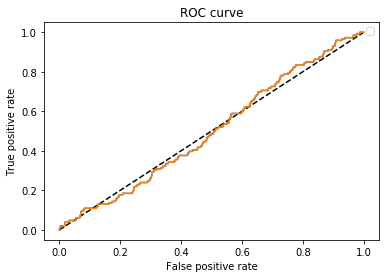

In [34]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [35]:
train_scores = []
valid_scores = []

for i in range(20):
    print('----- starting round {}'.format(i))
    model.fit(train, nb_epoch=10)
    train_scores.append(model.evaluate(train, [metric]))
    valid_scores.append(model.evaluate(valid, [metric]))

----- starting round 0
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


computed_metrics: [0.6531760735884506]
computed_metrics: [0.6111550940249333]
----- starting round 1
computed_metrics: [0.7597026868884256]
computed_metrics: [0.7166737123443061]
----- starting round 2
computed_metrics: [0.7732909813649462]
computed_metrics: [0.7313271944961636]
----- starting round 3
computed_metrics: [0.8028732867747517]
computed_metrics: [0.7196699515063472]
----- starting round 4
computed_metrics: [0.8283036705573283]
computed_metrics: [0.7169917639282289]
----- starting round 5
computed_metrics: [0.8272571642414196]
computed_metrics: [0.7307365130390192]
----- starting round 6
computed_metrics: [0.8420842368908561]
computed_metrics: [0.7115405609900021]
----- starting round 7
computed_metrics: [0.8462875256418507]
computed_metrics: [0.7144985502904001]
----- starting round 8
computed_metrics: [0.8556650513529295]
computed_metrics: [0.7152763970861573]
----- starting round 9
computed_metrics: [0.8624239198796881]
computed_metrics: [0.7142137681173856]
----- startin

In [0]:
import matplotlib.pyplot as plt

In [0]:
print(train_scores)

In [0]:
train_scores_v = [d['roc_auc_score'] for d in train_scores]
valid_scores_v = [d['roc_auc_score'] for d in valid_scores]

plt.plot(train_scores_v, range(0,201), label='training')
plt.plot(valid_scores_v, range(0,201), label='validation')
plt.title('ROC AUC Curve', size=14)
plt.xlabel('Training Round')
plt.ylabel('ROC AUC')
plt.xlim([0,200])
plt.legend()
plt.grid()

## Interpretation

Following the book's example, we trained the 1D convolution model with 10 epochs, 20 times. So the model has seen the data 200 times.

The metric we defined to assess the model was ROC AUC, short for area under the curve (AUC) for the receiver operating characteristic (ROC) curve. This is formed by plotting y (true positive rate) versus x (false positive rate). The more area under the curve, the better the model is at making correct predictions (true positive) versus incorrect predictions (false positives).

More information about the `roc_auc_score` metric can be found in the scikit-learn documentation: <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html>

With this in mind, we can see that the model is overfitting the data after two or three training rounds, as the training performance gets better and better while the validation performance levels off at around 70%.

# Adding Chromatin Accessibility Data

Following Chapter 6, we provide the model with additional data about chromatin accessibility.